#  Recycler Simulation

In [7]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('talk')

import copy

from scipy.constants import c, e, m_p

import PyHEADTAIL

from FERMImachines import RR

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.impedances.wakes import CircularResistiveWall, CircularResonator, WakeField, WakeTable

1
Synchrotron init. From kwargs: n_segments = 1
Synchrotron init. From kwargs: machine_configuration = '53MHz'
Synchrotron init. From kwargs: longitudinal_focusing = 'non-linear'
*** Maximum RMS bunch length 0.889766948349279m.
... distance to target bunch length: -5.6249e-01
... distance to target bunch length: 2.9519e-01
... distance to target bunch length: 2.6026e-01
... distance to target bunch length: 6.0106e-02
... distance to target bunch length: -8.4604e-02
... distance to target bunch length: 6.0186e-03
... distance to target bunch length: -1.5995e-04
... distance to target bunch length: 1.2451e-06
... distance to target bunch length: -1.5136e-06
--> Bunch length: 0.5700012450826168
--> Emittance: 0.06445306419261544
dipole_x Assuming ultrarelativistic wake.
*** PyHEADTAIL WARNING! You use multiturn wakes. The stored SliceSet instances from previous turns are converted from z to dt according to the current turn's gamma. If you accelerate this is only an approximation which bec

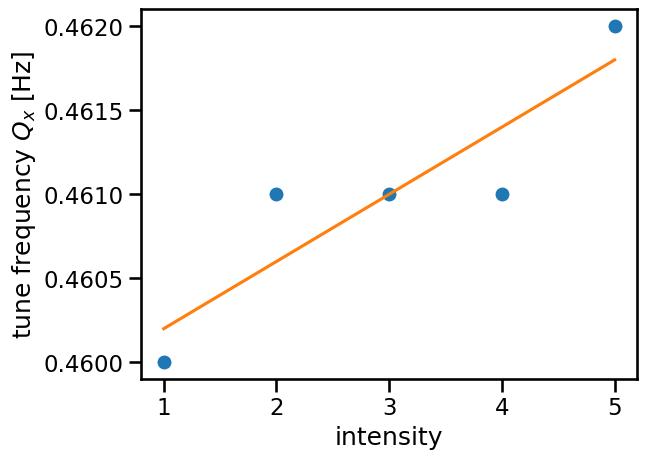

In [9]:
intensities =np.array([1,3,5])
tune_freqs = []
n_turns = 1000

for i, intensity in enumerate(intensities):
    print(intensity)
    machine = RR(n_segments=1, machine_configuration='53MHz', 
                longitudinal_focusing='non-linear')

    C = machine.circumference

    epsn_x = epsn_y = 2.5e-6 # in [m rad]

    bunch = machine.generate_6D_Gaussian_bunch_matched(
        n_macroparticles=int(1e5), intensity=intensity*1e11, 
        epsn_x=epsn_x, epsn_y=epsn_y, sigma_z=0.57)

    n_sigma_z = 2
    n_slices = 50
    uniform_bin_slicer = UniformBinSlicer(n_slices=n_slices, n_sigma_z=n_sigma_z)

    #wake_table = CircularResonator(R_shunt=1e6, frequency=1e9, Q=1)

    wakefile = 'RR_fullWake_resistiveWall_PyHTConvention.dat'
    wake_table = WakeTable(wakefile, ['time', 'dipole_x', 'dipole_y', 'quadrupole_x', 'quadrupole_y','nonsense'],n_turns_wake=5)   # Follow the order of the columns in the wake file here. If you want to exclude a component, change the name e.g. for the dipole y to 'no_dipole_y'.
    wake_field = WakeField(uniform_bin_slicer, wake_table) #, wake_table_k, wake_table_k)
    
    #wake_table = CircularResistiveWall(pipe_radius=5e-2, resistive_wall_length=C, conductivity=3e9, dt_min=1e-3/c, beta=bunch.beta, n_turns_wake=100)
    wake_field = WakeField(uniform_bin_slicer, wake_table)
    machine.one_turn_map.append(wake_field)
    
    x_rec = np.empty((n_turns, bunch.macroparticlenumber), dtype=np.float64)
    y_rec = np.empty((n_turns, bunch.macroparticlenumber), dtype=np.float64)
    
    for i in range(n_turns):
        if i % 100 == 0:
            print(i)
        for m in machine.one_turn_map:
            x_rec[i, :] = bunch.x
            y_rec[i, :] = bunch.y
            m.track(bunch)

    freqs = np.fft.rfftfreq(n_turns)
    #fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    for x, y in zip(x_rec.T[:1], y_rec.T[:1]):
        #ax[0].plot(freqs, np.abs(np.fft.rfft(x)))
        #ax[1].plot(freqs, np.abs(np.fft.rfft(y)))
        max_index = np.argmax(np.abs(np.fft.rfft(x)))
        max_freq = freqs[max_index]
        #print('tune freq =', max_freq, 'Hz')
    #ax[0].set_title('horizontal incoherent spectrum $x$')
    #ax[0].set_xlabel('$Q_x$')
    #ax[1].set_title('vertical incoherent spectrum $y$')
    #ax[1].set_xlabel('$Q_y$');
    #plt.show()

    #freqs = np.fft.rfftfreq(n_turns)
    #for x, y in zip(x_rec.T[:1], y_rec.T[:1]):
    #    max_index = np.argmax(np.abs(np.fft.rfft(x)))
    #    max_freq = freqs[max_index]

    tune_freqs.append(max_freq)

plt.plot(intensities, tune_freqs, 'o')
plt.xlabel('intensity')
plt.ylabel('tune frequency $Q_x$ [Hz]')
a,b = np.polyfit(intensities, tune_freqs, 1)
plt.plot(intensities,  intensities*a+b, label='linear fit')
plt.show()